In [ ]:
<div style="text-align:center">
    <h1>
        Policy Iteration
    </h1>
</div>
<br>

<div style="text-align:center">
    <p>
        In this notebook we are going to look at a dynamic programming algorithm called policy iteration. In it, we will iteratively interleave two processes: policy evaluation and policy improvement, until the optimal policy and state values are found.
    </p>
</div>

<br><br>
<div style="text-align:center">
    <b>This notebook belongs to section 3 of the course "Reinforcement Learning: beginner to master".</b>
    <br><br>
    <a href="https://www.udemy.com">Reinforcement Learning: beginner to master</a> (English)
    <br>
    <a href="https://www.udemy.com">Reinforcement Learning: de principiante a maestro</a> (Spanish)
</div>

<br>

<table style="width:35%">
  <tr style="background-color: transparent">
    <td style="width: 45%">
        <a target="_parent" href="https://www.evlabs.io" style="float: center">
            <img src="img/evlabs-square.png" width="75"/>
        </a> 
    </td>
    <td valign="bottom">
        <a target="_parent" href="https://www.youtube.com/channel/UCksRNSzWuMV5IfdrPlglqqw">
            <img src="img/YouTube.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://www.linkedin.com/company/evlabs">
            <img src="img/LinkedIn.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://twitter.com/evelabs">
            <img src="img/Twitter.png" width="35"/>
        </a> 
    </td>
    <td>
        <a target="_parent" href="https://github.com/escape-velocity-labs/">
            <img src="img/GitHub.png" width="35"/>
        </a> 
    </td>

  </tr>
  <tr style="background-color: transparent">
    <th style="text-align: center; width: 70%">Escape Velocity Labs</th>
  </tr>

</table>

<br>

## Import the necessary software libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from envs import Maze
from utils import plot_policy, plot_values, test_agent

## Initialize the environment

In [2]:
env = Maze()

C:\Users\steve\mambaforge\envs\rl-beginner-master\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


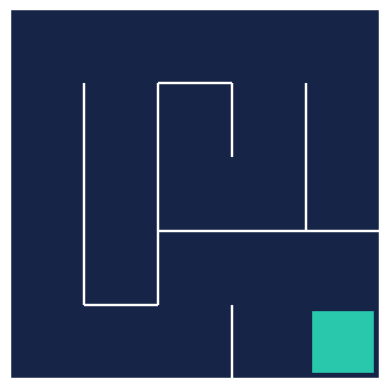

In [3]:
frame = env.render(mode='rgb_array')
plt.axis('off')
plt.imshow(frame)

In [4]:
print(f"Observation space shape: {env.observation_space.nvec}")
print(f"Number of actions: {env.action_space.n}")

Observation space shape: [5 5]
Number of actions: 4


## Define the policy $\pi(\cdot|s)$

#### Create the policy $\pi(\cdot|s)$

In [5]:
policy_probs = np.full((5, 5, 4), 0.25)

In [6]:
def policy(state):
    return policy_probs[state]

#### Test the policy with state (0, 0)

In [7]:
action_probabilities = policy((0,0))
for action, prob in zip(range(4), action_probabilities):
    print(f"Probability of taking action {action}: {prob}")

Probability of taking action 0: 0.25
Probability of taking action 1: 0.25
Probability of taking action 2: 0.25
Probability of taking action 3: 0.25


#### See how the random policy does in the maze

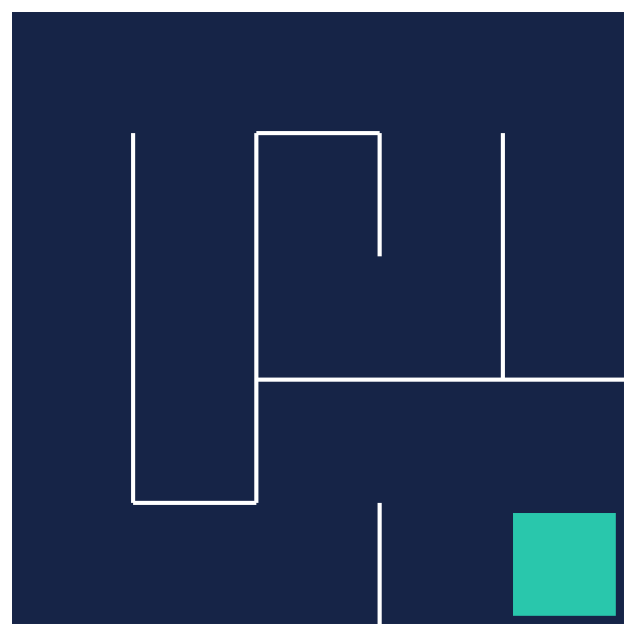

In [8]:
test_agent(env, policy, episodes=1)

#### Plot the policy

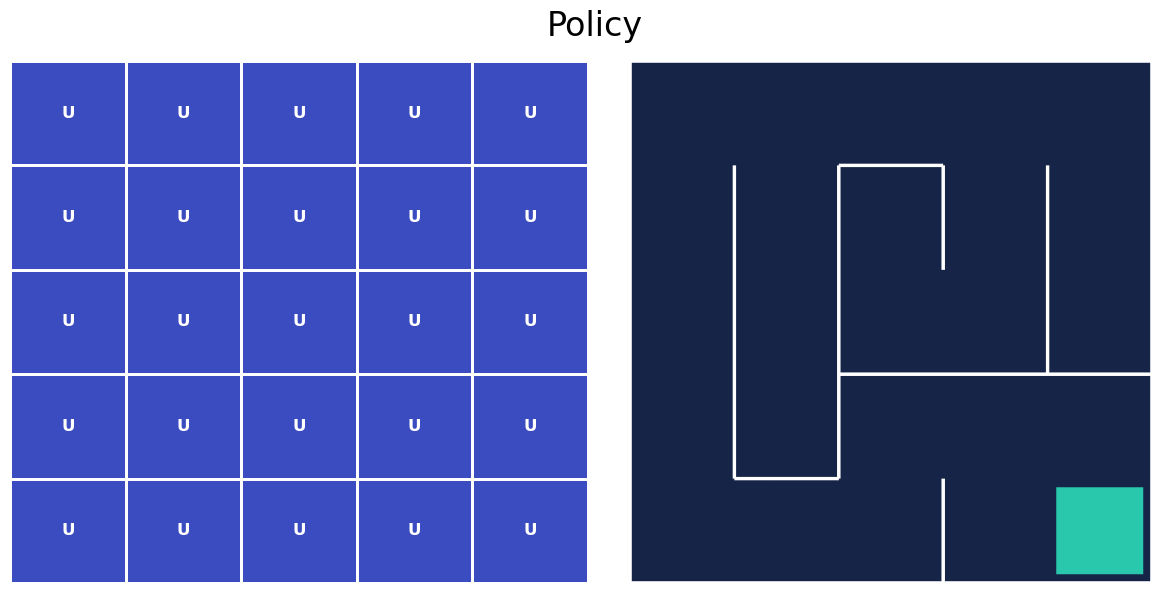

In [8]:
plot_policy(policy_probs, frame)

## Define value table $V(s)$

#### Create the $V(s)$ table

In [9]:
state_values = np.zeros(shape=(5,5))

#### Plot $V(s)$

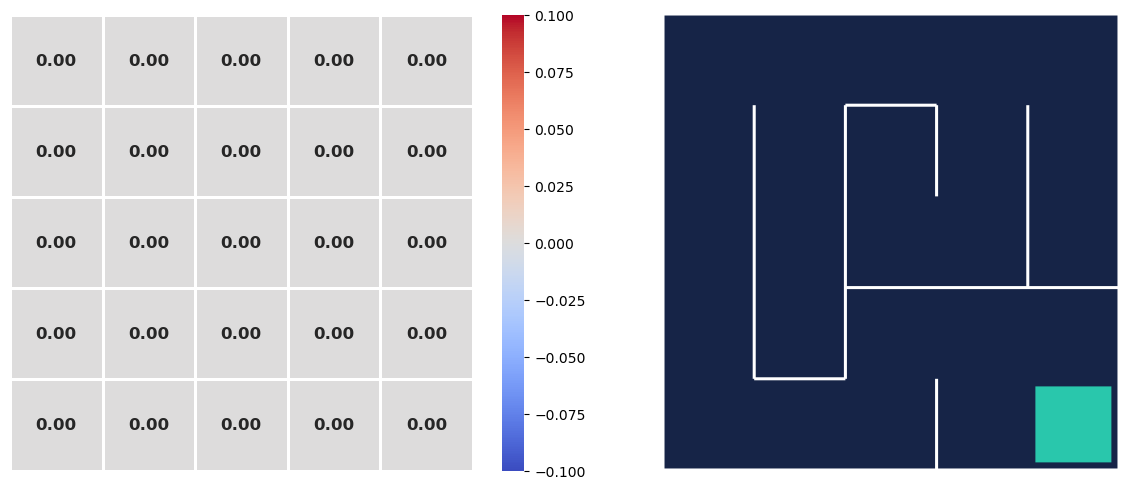

In [10]:
plot_values(state_values, frame)

## Implement the Policy Iteration algorithm

</br>

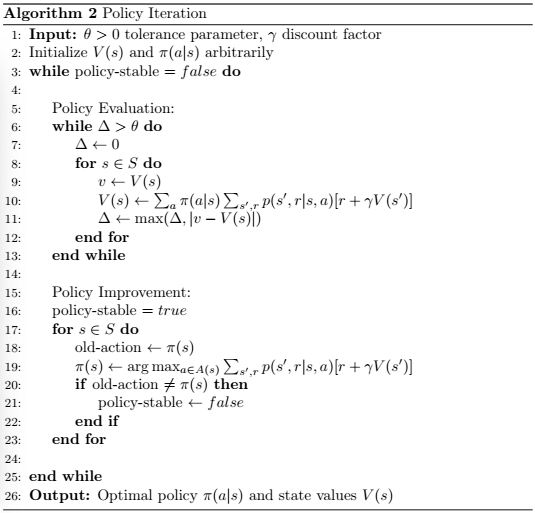

<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>

In [11]:
def policy_evaluation(policy_probs, state_values, theta=1e-6, gamma=0.99):
    """

    :param policy_probs: table of probabilities of the policy choosing each action
    :param state_values: the value table, value of the states
    :param theta: maximum error in the value estimations
    :param gamma: discount factor when computing the returns
    :return: None
    """
    # set delta to a very large number to ensure entering the main loop
    delta = float("inf")

    # while delta is greater than theta
    while delta > theta:
        # set delta to zero
        delta = 0
        # iterate over all s's within S, since a 5x5 grid need to go row by col
        for row in range(5):
            for col in range(5):
                # v = V(s)
                old_value = state_values[(row, col)]
                new_value = 0
                # retrieve probabilities of choosing each action in the present state
                action_probabilities = policy_probs[(row, col)]

                # compute the new value for the state V(s)
                # sum of all the returns we can achieve with each action: pi(a|s)
                for action, prob in enumerate(action_probabilities):
                    next_state, reward, _, _ = env.simulate_step((row, col), action)
                    # prob of next state:p(s') * reward + gamma * next state value: V(s')
                    new_value += prob * (reward + gamma * state_values[next_state])

                state_values[(row, col)] = new_value

                # set delta to the max between delta or difference between the old value and new value
                delta = max(delta, abs(old_value - new_value))

In [12]:
def policy_improvement(policy_probs, state_values, gamma=0.99) -> bool:
    """

    :param policy_probs: table of probabilities of the policy choosing each action
    :param state_values: the value table, value of the states
    :param gamma: discount factor when computing the returns
    :return: True if the policy is stable else False
    """
    # Set the stop condition to true
    policy_stable = True

    # Iterate over all of the state values s in S.
    for row in range(5):
        for col in range(5):
            # set the old action to the max of all of the action probabilities at this position
            # old_action = pi(s)
            old_action = policy_probs[(row, col)].argmax()

            new_action = None
            max_qsa = float("-inf")
            # iterate over all the possible actions
            # pi(s) = argmax sum p(s') * (reward + gamma V(s'))
            for action in range(4):
                # evaluate the next action
                next_state, reward, _, _ = env.simulate_step((row, col), action)
                # the current action qsa
                qsa = reward + gamma * state_values[next_state]

                # if the new qsa is greater than what we have found before, set it as the max
                if qsa > max_qsa:
                    new_action = action
                    max_qsa = qsa
            # change the policy probabilities so the best action is chosen
            action_probs = np.zeros(4)
            action_probs[new_action] = 1
            policy_probs[(row, col)] = action_probs

            # Did we choose a different action from the old action?
            if new_action != old_action:
                policy_stable = False

    # If even one policy changed, then policy_stable is False.
    return policy_stable

In [13]:
def policy_iteration(policy_probs, state_values, theta=1e-6, gamma=0.99):
    policy_stable = False

    while not policy_stable:
        policy_evaluation(policy_probs, state_values, theta, gamma)
        plot_values(state_values, frame)

        policy_stable = policy_improvement(policy_probs, state_values, gamma)
        plot_policy(policy_probs, frame)

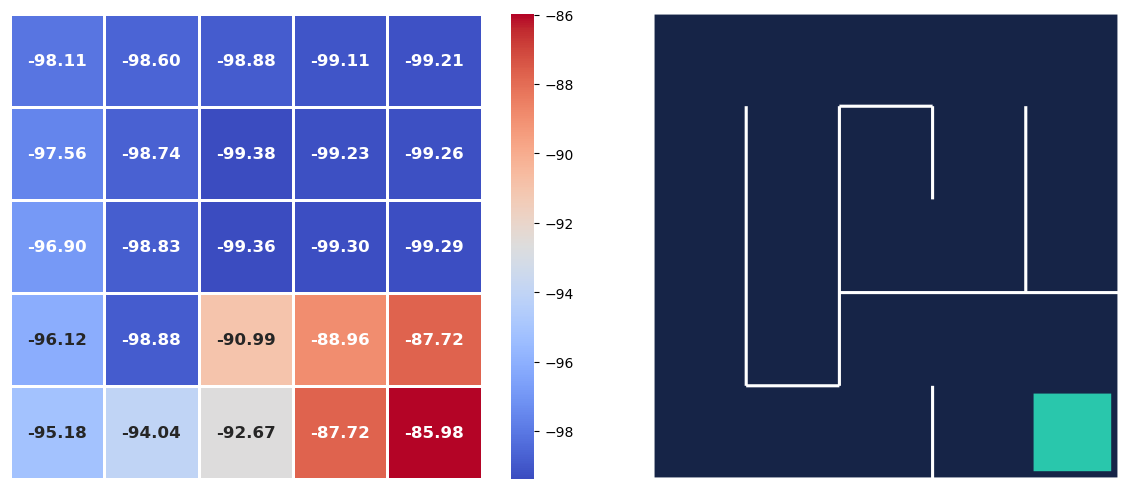

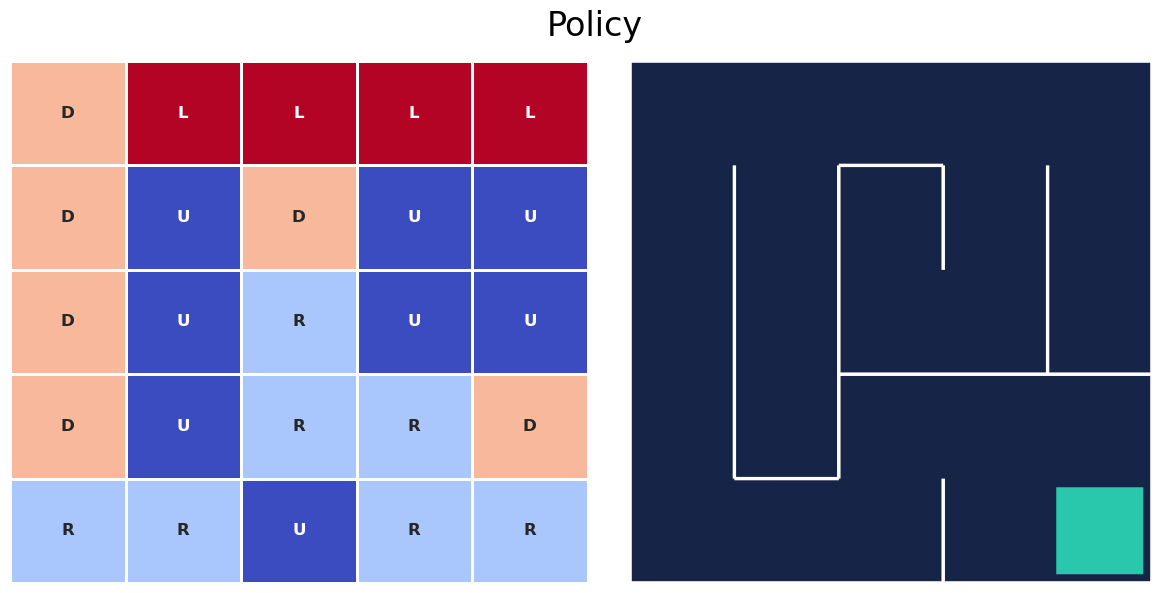

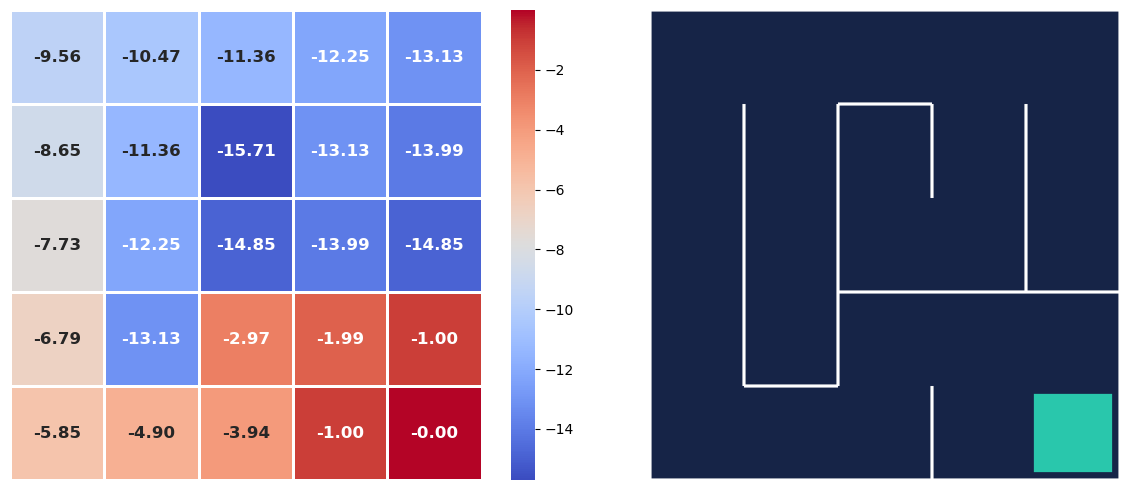

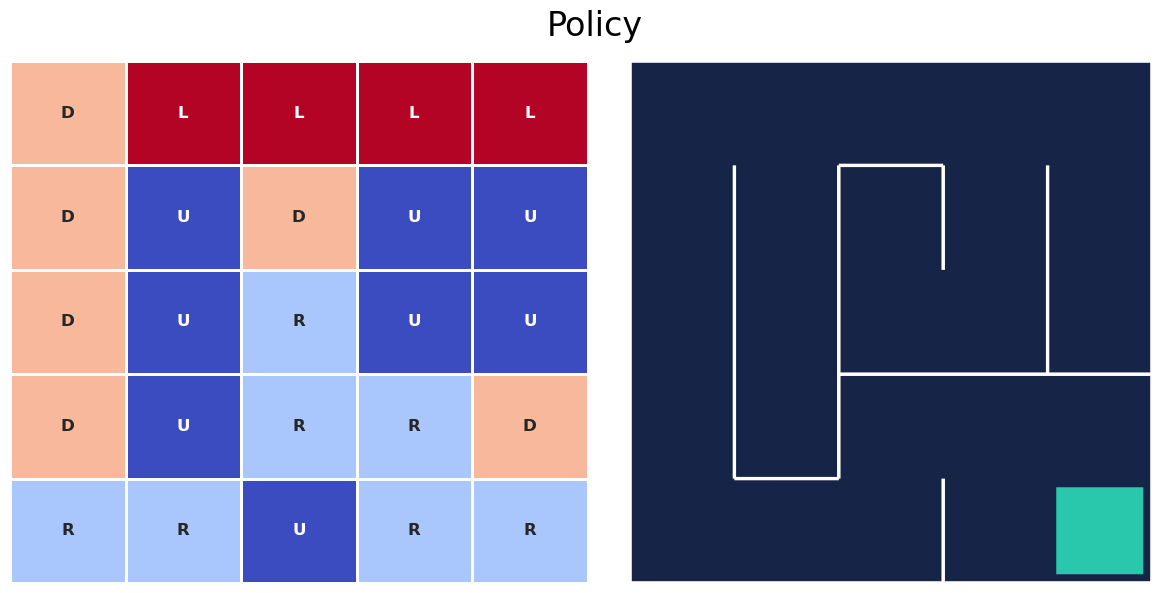

In [14]:
policy_iteration(policy_probs, state_values)

## Show results

#### Test the resulting agent

KeyboardInterrupt: 

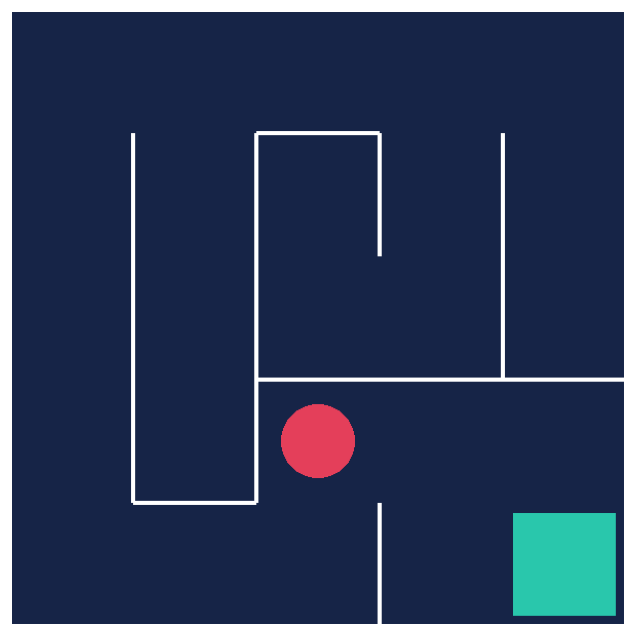

In [15]:
test_agent(env, policy)

## Resources

[[1] Reinforcement Learning: An Introduction. Ch. 4: Dynamic Programming](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)